### Outlier Detection
>The purpose of this notebook is to examine different techinques that can be used for outlier detection. I plan on using the crime data from the file uscrime.txt (http://www.statsci.org/data/general/uscrime.txt, 
description at http://www.statsci.org/data/general/uscrime.html), test to see whether there are an 
outliers in the last column (number of crimes per 100,000 people).

To look at any potential outliers in the uscrime.txt data I'll use the gubbs.test() function that is a part of the outliers package. The syntax for the Grubbs test can be found here: https://www.rdocumentation.org/packages/outliers/versions/0.15/topics/grubbs.test. The Grubbs test is a statistical test designed to detect outliers in a univariate dataset that follows a normal distribution. The test identifies an outlier by measuring how far a data point deviates from the mean, relative to the standard deviation of the dataset. It’s based on the assumption that the largest absolute deviation from the mean is a potential outlier. I found the explanation in the link below helpful in understanding exactly how the Grubbs test works: https://medium.com/data-and-beyond/outlier-detection-in-r-grubbs-test-9f2848d7c210:

But to be able to interpret the results of the function I need to understand the outputs it provides, specifically the G, U, p-value, and alternative hypothesis. This G statistic is the difference between the sample mean and either the smallest or largest data value, divided by the standard deviation. You can compare this value against a critical value from the Grubbs’ distribution table to confirm that the value is not part of the normal variation of the data. The U value is a ratio of sample variances with and without the suspected outlier. The p-value is a probability that measures the evidence against the null hypothesis. A smaller p-value provides stronger evidence against the null hypothesis. So if we get a small p-value (typically <0.05), that indicates that the suspected point is statistically different from the rest of the data, suggesting it’s an outlier.

Now that I have a better understanding of how the Grubbs test works I am going to follow the steps below to look at any potential outliers in the Crime column of our data:

1) Explore the data to gain a better understanding of the dataset
2) Check that the data is normally distributed
3) Run the Grubbs test for the maximum and minimum values
4) Interpret the results of the test and decide if any of the points are outliers
5) Compare the results by examining the data distribution visually with a box and whisker plot

#### Step 1 - Explore the Data
For this step I am going to visually inspect the data, get summary statistics to get a sense of the values in the data, and read about the data to understand what the values in each column represent. I'll start by loading the libraries I need for this analysis and loading the data.

In [45]:
# Load libraries needed for analysis
# Outliers contains the Grubbs.test function and the pastecs library provides a statistical summary of the data
library(outliers)
library(pastecs)
library(ggplot2)
library(dplyr)

In [2]:
# Load the data
crime_data <- read.table("uscrime.txt", header = TRUE)

In [3]:
# Visually inspect the data, for this report only printed the first few rows but inspected all of them
head(crime_data)

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682


In [4]:
# Get summary statistics of the data
summary(crime_data)

       M               So               Ed             Po1       
 Min.   :11.90   Min.   :0.0000   Min.   : 8.70   Min.   : 4.50  
 1st Qu.:13.00   1st Qu.:0.0000   1st Qu.: 9.75   1st Qu.: 6.25  
 Median :13.60   Median :0.0000   Median :10.80   Median : 7.80  
 Mean   :13.86   Mean   :0.3404   Mean   :10.56   Mean   : 8.50  
 3rd Qu.:14.60   3rd Qu.:1.0000   3rd Qu.:11.45   3rd Qu.:10.45  
 Max.   :17.70   Max.   :1.0000   Max.   :12.20   Max.   :16.60  
      Po2               LF              M.F              Pop        
 Min.   : 4.100   Min.   :0.4800   Min.   : 93.40   Min.   :  3.00  
 1st Qu.: 5.850   1st Qu.:0.5305   1st Qu.: 96.45   1st Qu.: 10.00  
 Median : 7.300   Median :0.5600   Median : 97.70   Median : 25.00  
 Mean   : 8.023   Mean   :0.5612   Mean   : 98.30   Mean   : 36.62  
 3rd Qu.: 9.700   3rd Qu.:0.5930   3rd Qu.: 99.20   3rd Qu.: 41.50  
 Max.   :15.700   Max.   :0.6410   Max.   :107.10   Max.   :168.00  
       NW              U1                U2            

In [5]:
# Output the data class for each column
t(sapply(crime_data, class))

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
numeric,integer,numeric,numeric,numeric,numeric,numeric,integer,numeric,numeric,numeric,integer,numeric,numeric,numeric,integer


In [6]:
# Double check size of the data
cat('Rows',' ','Columns')
t(dim(crime_data))

Rows   Columns

47,16


In [7]:
# Get the summary statistics for the Crimes column
stat.desc(crime_data[,16])

nbr.val     nbr.null       nbr.na          min          max        range 
4.700000e+01 0.000000e+00 0.000000e+00 3.420000e+02 1.993000e+03 1.651000e+03 
         sum       median         mean      SE.mean CI.mean.0.95          var 
4.253900e+04 8.310000e+02 9.050851e+02 5.641514e+01 1.135578e+02 1.495854e+05 
     std.dev     coef.var 
3.867627e+02 4.273219e-01

This lets me know that I have a table with 47 rows and 16 columns. The data is a combination of integer and float (numeric) values and the Crime column has a minimum value of 342 and a maximum value of 1993 giving it a range of 1651. The median and mean are 831 and 905 respectively, and the standard deviation is 386.76. Looking at the statsci.org description of the data I see it is data on the effect of punishment regimes on crime rates for 47 stats in the USA for 1960. A description of the attributes of the data taken from the website can be seen below:

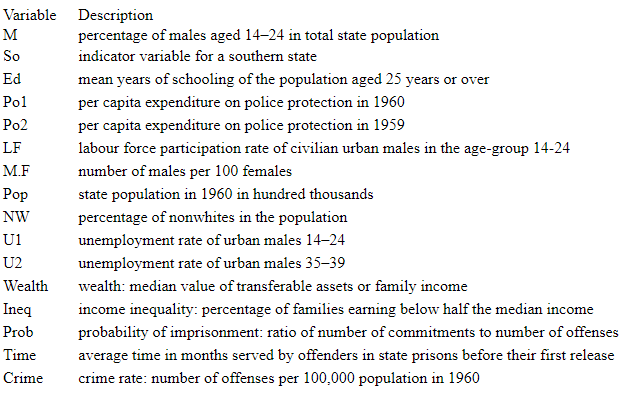

#### Step 2 - Check that the Data is Normally Distributed
The Grubbs test only works if the data is normally distributed so before applying it I am going to check that it fits a normal distribution. I found four methods for checking the normality of a dataset at https://www.statology.org/test-for-normality-in-r/. Since they are all relatively simple and I'm interested in learning the various methods I'll try the histogram, Q-Q plot, and Shapiro-Wilk Test. I am not running the Kolmogorov–Smirnov test because it is used for data with n ≥ 50 and our dataset has n = 47.

##### Option 1 - Histogram

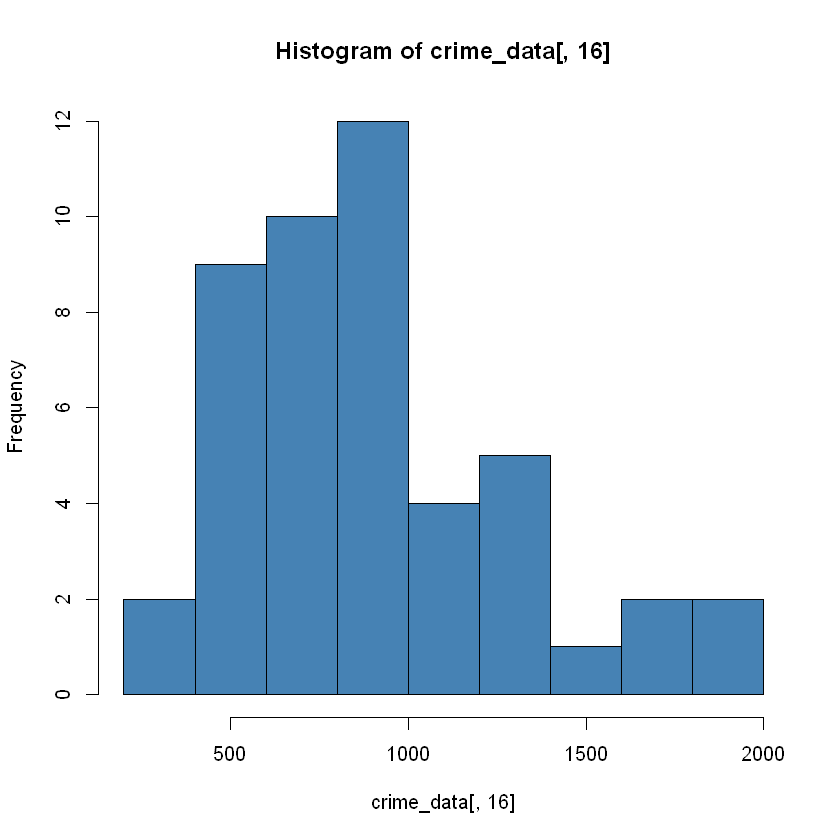

In [8]:
# Plot historgram
hist(crime_data[,16], col='steelblue')

##### Option 2 - Create a Q-Q Plot

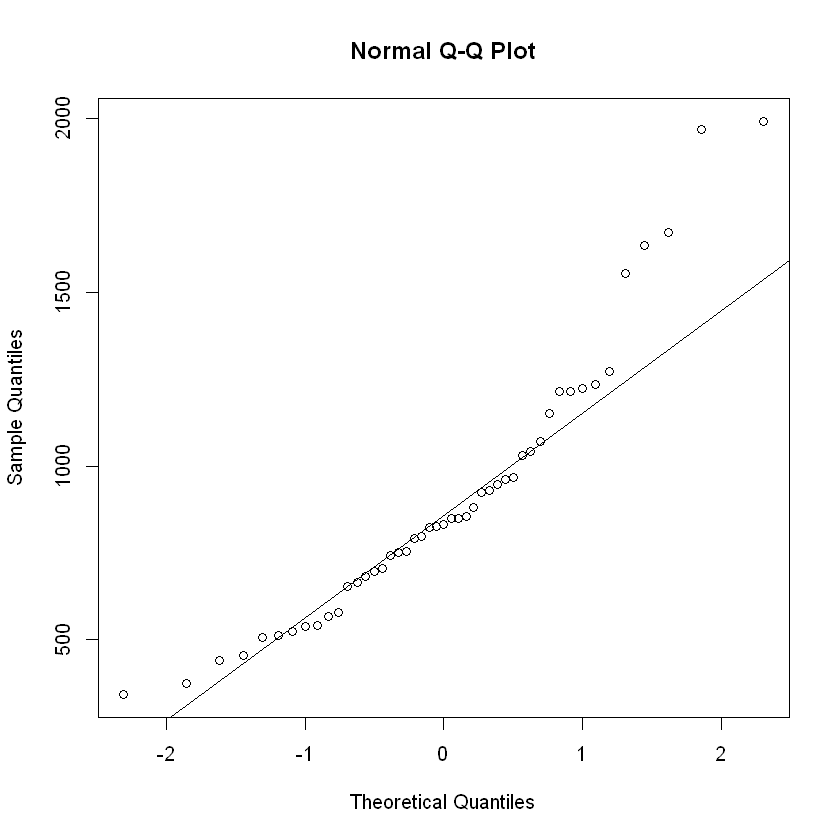

In [9]:
qqnorm(crime_data[,16])
qqline(crime_data[,16])

##### Option 3 - Perform a Shapiro-Wilk Test

In [10]:
shapiro.test(crime_data[,16])


	Shapiro-Wilk normality test

data:  crime_data[, 16]
W = 0.91273, p-value = 0.001882


After reviewing the results of all three tests, it's clear that the values actually indicate that our **data is not normally distributed and therefore the Grubbs test should not be used**. The histogram has a general bell shape but does show higher density at the lower values, the Q-Q plot shows that some of the values start to diverge from the QQ line at the higher values, and the Shapiro-Wilk test gave small p-values that indicate the data might not be normally distributed. All three tests indicate that our data is not normally distributed and therefore using the Grubbs test would not be appropriate. That means that it might be appropriate to use a transformation technique on the data to insure a normal distribution for the Grubbs test or use a different test to look for outliers. However, for the purpose of this homework I am going to move forward with the Grubbs test without performing any transformations and then again after transforming the results to see the difference. I am also going to try a few different outlier detection methods.

#### Step 3 - Run the Grubbs Test for the Maximum and Minimum Values
Next I will run the Grubbs test for both the maximum and minimum value, the Grubbs test can also check for two outliers on opposite tails and for two outliers in one tail (only works on n between 3-30) but I am not including those in this analysis. 

In [11]:
# Check the minimum value
grubbs.test(crime_data[,16], type = 10, opposite = TRUE)


	Grubbs test for one outlier

data:  crime_data[, 16]
G = 1.45589, U = 0.95292, p-value = 1
alternative hypothesis: lowest value 342 is an outlier


In [12]:
# Check the maximum value
grubbs.test(crime_data[,16], type = 10)


	Grubbs test for one outlier

data:  crime_data[, 16]
G = 2.81287, U = 0.82426, p-value = 0.07887
alternative hypothesis: highest value 1993 is an outlier


#### Step 4 - Interpret the Results of the Tests
Looking at the output from the Grubbs test for the minimum value it is clear that it is not an outlier, the p-value is 1 and would need to be < 0.05 to reject the null hypothesis at the common significance level of 5%. The maximum value requires more analysis, we are able to choose the significance level (typically α = 0.05 is used). The p-value we get of 0.07887 is above the typical significance level so would mean that we would accept the null hypothesis and wouldn't be able to conclude that the maximum value is an outlier. If I decided to use a larger significance level (for example α = 0.1) I would need to check what the Grubbs' critical value is for our sample size. Looking at the table at http://www.sediment.uni-goettingen.de/staff/dunkl/software/pep-grubbs.pdf, it shows that the G value would need to be greater than 0 which it is. As a result, I can conclude that the maximum value is an outlier at the 0.1 significance level. All of this is irrelevant because the data is not normally distributed but provided good insight into the Grubbs test and it's implementation.

#### Step 5 - Box and Whisker Plot
Lastly, I want to visualize the distribution of the data with a box and whisker plot to see how it compares to the Grubs test results.

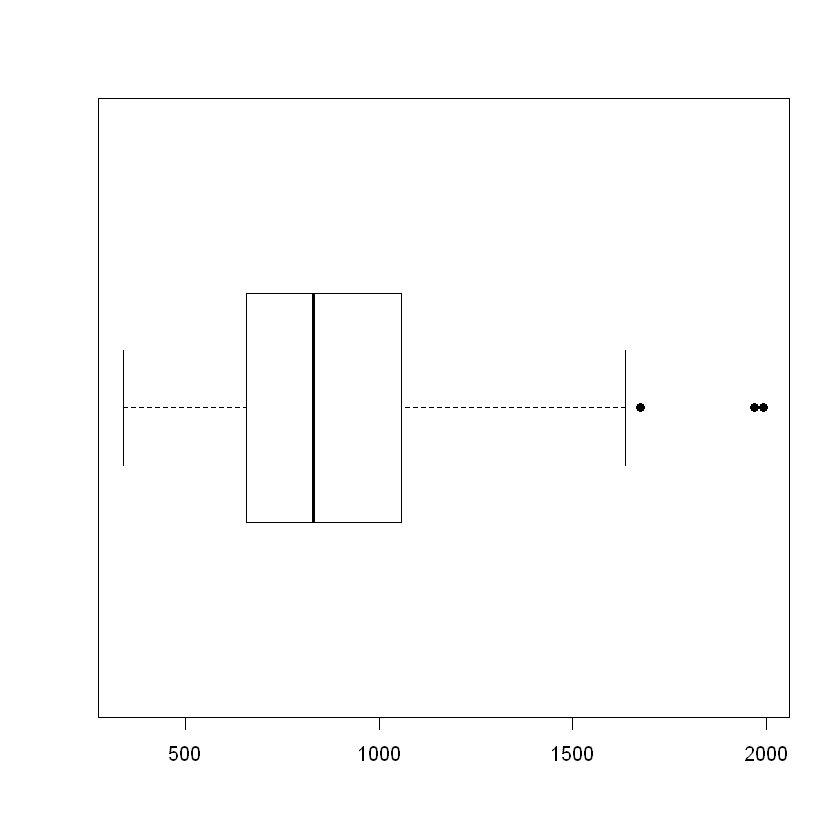

In [13]:
boxplot(crime_data[,16], pch=16, horizontal = TRUE)

#### Conclusion
Looking at the box and whisker plot the three largest values would be considered outliers from a stastical standpoint, however when looking at the Grubbs test they would only be considered such at a very high signifance level (α >= 0.1). Furthermore, when looking at what the data represents it is logical that their would be a few states with significantly higher crime rates. And not including a state in the dataset wouldn't make sense regardless of what the Grubbs test told us as the purpose of the dataset is to see the variation in crime rates for each state.

### Redo with Normalized Data
Since the original dataset didn't meet the requirements of having a normal distribution for the Grubbs test, I am going to normalize the data and try running the test again. Their are multiple ways to normalize the data, some of the ones I found were using log transformations, standard scaling, min-max scaling, and Z-score standardization. I am going to use logarithmic transformations and follow the steps below to see how it effects the results of the grubbs test:
1) Normalize the data using logarithmic transformations
2) Check that the data is normally distributed
3) Run the Grubbs test for the maximum and minimum values
4) Interpret the results of the test and decide if any of the points are outliers
5) Examine the data distribution visually with a box and whisker plot

#### Step 1 - Normalize the data
I am going to apply a logarithmic transformation on the crime data to achieve a normal distribution.

In [14]:
n_data <- log(crime_data[,16])

#### Step 2 - Check that the Data is Normally Distributed
Next I am going to run all four tests that I had previously to see if the data is normally distributed after the logarithmic transformation.

##### Option 1 - Histogram

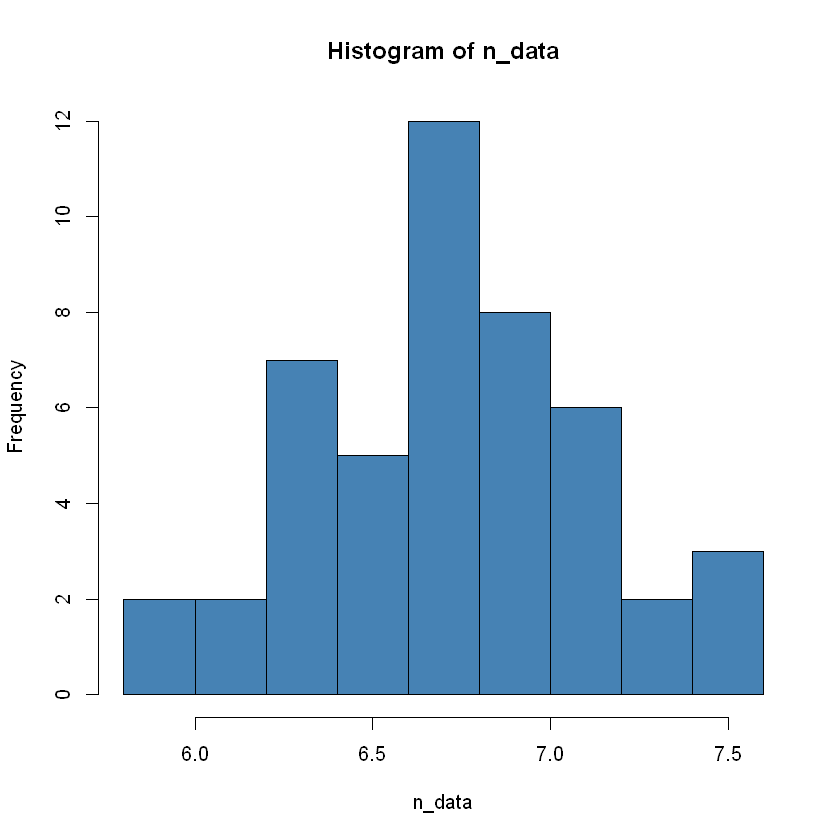

In [15]:
# Plot historgram
hist(n_data, col='steelblue')

##### Option 2 - Create a Q-Q Plot

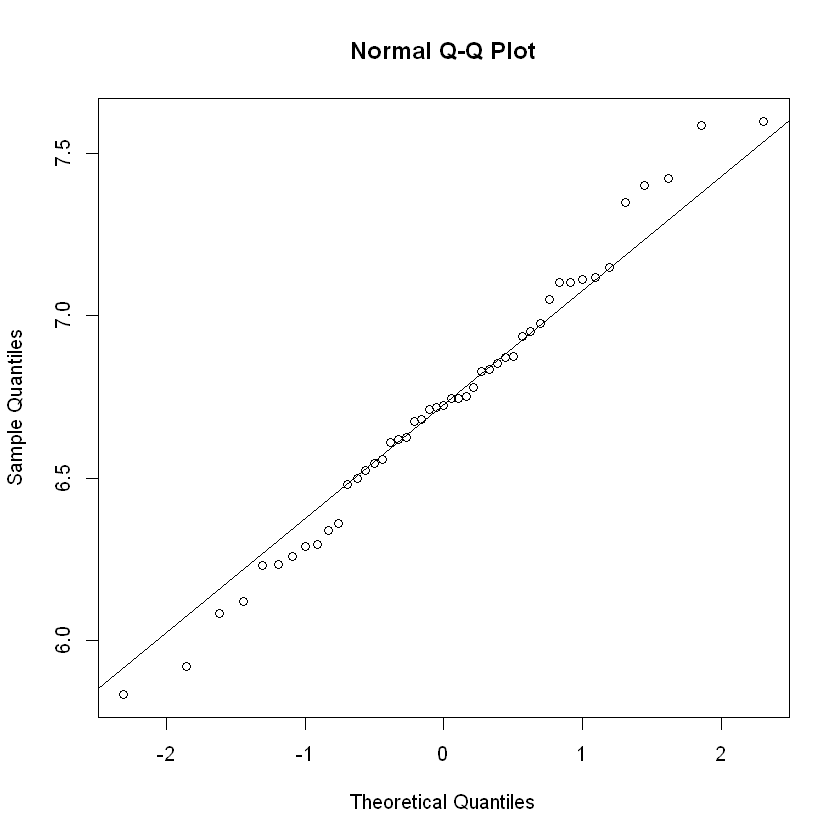

In [16]:
qqnorm(n_data)
qqline(n_data)

##### Option 3 - Perform a Shapiro-Wilk Test

In [17]:
shapiro.test(n_data)


	Shapiro-Wilk normality test

data:  n_data
W = 0.98709, p-value = 0.8778


After reviewing the results I can see that the data is now normally distributed. The histogram shows a true bell curve shape, the QQ-plot shows that most of the points are centered around the QQ-line, and the p-value fromt eh Shapiro-Wilks test is above 0.05.

#### Step 3 - Run the Grubbs Test for the Maximum and Minimum Values
Next I will run the Grubbs test for both the maximum and minimum value using the normalized dataset, the Grubbs test can also check for two outliers on opposite tails and for two outliers in one tail (only works on n between 3-30) but I am not including those in this analysis.

In [18]:
# Check the minimum value
grubbs.test(n_data, type = 10, opposite = TRUE)


	Grubbs test for one outlier

data:  n_data
G = 2.12247, U = 0.89994, p-value = 0.712
alternative hypothesis: highest value 7.59739632021279 is an outlier


In [19]:
# Check the maximum value
grubbs.test(n_data, type = 10)


	Grubbs test for one outlier

data:  n_data
G = 2.16544, U = 0.89585, p-value = 0.6329
alternative hypothesis: lowest value 5.8348107370626 is an outlier


#### Step 4 - Interpret the Results of the Tests
Looking at the output from the Grubbs test for the minimum value it is clear that it is not an outlier, the p-value is 0.712 and would need to be < 0.05 to reject the null hypothesis at a significance level of 5%. The maximum value showed similar results, the p-value is 0.6329 which again is far too large to reject the null hypothesis.

#### Step 5 - Box and Whisker Plot
Lastly, I want to visualize the distribution of the normalized data with a box and whisker plot to see how it compares to the Grubs test results.

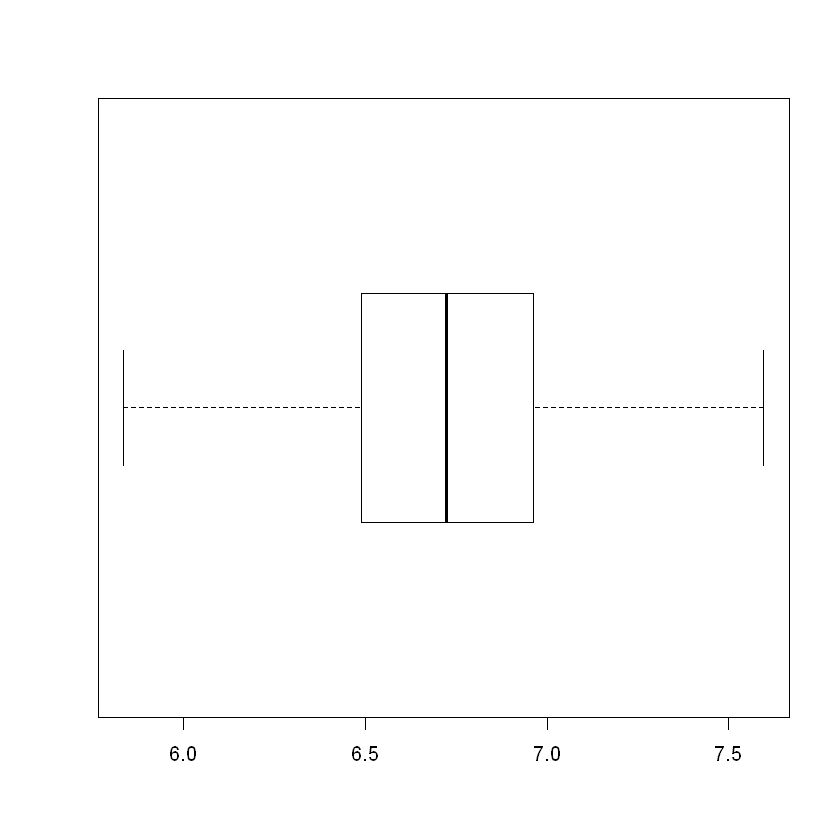

In [20]:
boxplot(n_data, pch=16, horizontal = TRUE)

### Hampel Filter Method to Detect Outliers
Lastly, I am going to try to use the Hampel Filter method on the original dataset to see if it detects any outliers. I found information about this method at https://statsandr.com/blog/outliers-detection-in-r/#statistical-tests. It essentially states that a point is considered an outlier if it is outside the interval (I) formed by the median, plus or minus 3 median absolute deviations. It is given by the equation:
$$ I = [median - 3 * MAD; median + 3 * MAD] $$
Where MAD is the absolute deviation and is defined as:
$$ MAD = median([Xi - Xmedian]) $$

In [21]:
lower_bound <- median(crime_data[,16]) - 3 * mad(crime_data[,16], constant = 1)
upper_bound <- median(crime_data[,16]) + 3 * mad(crime_data[,16], constant = 1)
cat("Lower bound is:", lower_bound, "Upper bound is:", upper_bound)

Lower bound is: 195 Upper bound is: 1467

According to this method, all observations below 195 and above 1467 could be an outlier. This does indicate we have several potential outliers. These point would warrent further inspection but like stated in the conclusion above, due to the nature of the dataset it is unlikely that we would make any changes to the dataset. Looking at our data the following indices are for values that fall outside of the determined range:

In [22]:
outlier_ind <- which(crime_data[,16] < lower_bound | crime_data[,16] > upper_bound)
crime_data[outlier_ind, ]

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
2,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
4,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
8,13.1,1,10.9,11.5,10.9,0.542,96.9,50,17.9,0.079,3.5,4720,20.6,0.040099,24.5988,1555
11,12.4,0,10.5,12.1,11.6,0.580,96.6,101,10.6,0.077,3.5,6570,17.0,0.016201,41.6000,1674
26,13.1,0,12.1,16.0,14.3,0.631,107.1,3,7.7,0.102,4.1,6740,15.2,0.041698,22.1005,1993
